In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [2]:
from sys import path as sys_path
sys_path.append('../sunxspex')
from sunxspex.sunxspex_fitting.fitter import SunXspex

In [3]:
from IPython.core.display import display, HTML
display(HTML('<style>.container{width:100% !important;}</style>'))

## Set up some plotting numbers

In [4]:
spec_single_plot_size = (8,10)
spec_plot_size = (25,10)
spec_font_size = 18
default_font_size = 10
x_limits, y_limits = [1.6,8.5], [1e-1,1e3]

# Load in one spectrum and fit it with one model

In [5]:
# First, load in your data files, here we load in 1 spectrum
_dir = "../nustarData/m3_time2628/"
spec = SunXspex(pha_file=[_dir+'nu80414202001A06_chu23_S_cl_grade0_sr.pha'])
                
# All the data can be accessed via spec.loaded_spec_data
                
# Next you can define a model, here we go for a single isothermal model
spec.model = "f_vth"

In [6]:
print(spec.params)

              Status  Value       Bounds       Error
T1_spectrum1    free    1.0  (0.0, None)  (0.0, 0.0)
EM1_spectrum1   free    1.0  (0.0, None)  (0.0, 0.0)


In [7]:
# Set your count energy fitting range. Here we choose 2.5--8.1 keV
spec.energy_fitting_range = [2.5,8.1]

In [8]:
# To set the initial value and boundary of your parameters we can do the following.
spec.params["T1_spectrum1"] = {"Value":4, "Bounds":(2.5, 8)} # units MK
spec.params["EM1_spectrum1"] = {"Value":0.3, "Bounds":(1e-2, 8e-1)} # units 1e46 cm^-3

# Setting spec.params["param_spec"] = string will set the Status, spec.params["param_spec"] = int or float will set the Value, spec.params["param_spec"] = tuple will set the Bounds
# I.e., spec.params["T1_spectrum1"] = {"Value":3.05, "Bounds":(2.5, 6)} is the same as doing spec.params["T1_spectrum1"]=3.05 and then spec.params["T1_spectrum1"]=(2.5, 6)

print(spec.params)

              Status  Value       Bounds       Error
T1_spectrum1    free    4.0     (2.5, 8)  (0.0, 0.0)
EM1_spectrum1   free    0.3  (0.01, 0.8)  (0.0, 0.0)


In [9]:
%%time
# Once data has been loaded and a model set then the data can be fit with:
minimised_params = spec.fit()
# Any kwargs passed to fit will be sent to Scipy's minimize, e.g., tol=1e-6 for setting a tolerance for the fit.
# spec.params will be updated with the best fit values and errors (if obtained) updated too.

CPU times: user 2.67 s, sys: 641 ms, total: 3.31 s
Wall time: 1.01 s


In [10]:
print(spec.params)

              Status     Value       Bounds  \
T1_spectrum1    free  4.748163     (2.5, 8)   
EM1_spectrum1   free  0.303051  (0.01, 0.8)   

                                                      Error  
T1_spectrum1   (0.016572586985611096, 0.016572586985611096)  
EM1_spectrum1    (0.00458303792059048, 0.00458303792059048)  


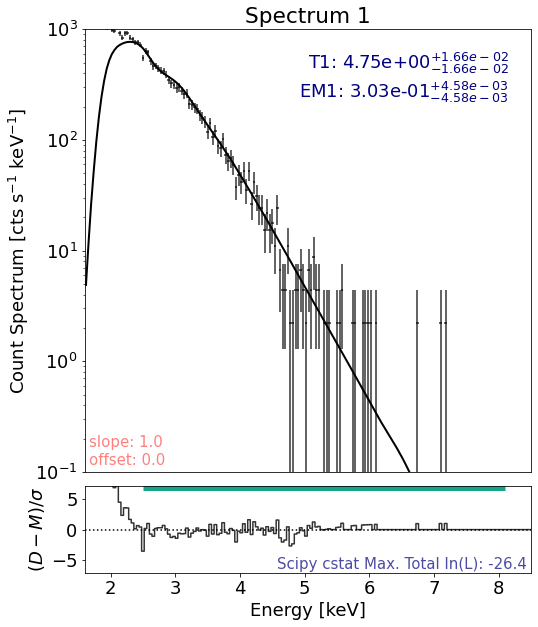

In [11]:
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_single_plot_size)
axes, res_axes = spec.plot()
for a in axes:
    a.set_xlim(x_limits)
    a.set_ylim(y_limits)
plt.show()
plt.rcParams['font.size'] = default_font_size

## The data loader class

The data loader class (LoadSpec in data_loader.py) should be the only code that most probably is not instrument agnostic. This works well with NuSTAR data but it job is to essentially create the following dictionary for each loaded spectrum, found with the attribute `loaded_spec_data`:
```python
spec_info = {"photon_channel_bins":channel_bins, 
             "photon_channel_mids":np.mean(channel_bins, axis=1), 
             "photon_channel_binning":channel_binning, 
             "count_channel_bins":channel_bins, 
             "count_channel_mids":np.mean(channel_bins, axis=1), 
             "count_channel_binning":channel_binning, 
             "counts":counts, 
             "count_rate":count_rate, 
             "count_rate_error":count_rate_error, 
             "effective_exposure":eff_exp,
             "srm":srm,
             "extras":{"pha.file":f_pha,
                       "arf.file":f_arf,
                       "arf.e_lo":e_lo_arf,
                       "arf.e_hi":e_hi_arf,
                       "arf.effective_area":eff_area,
                       "rmf.file":f_rmf,
                       "rmf.e_lo":e_lo_rmf,
                       "rmf.e_hi":e_hi_rmf,
                       "rmf.ngrp":ngrp,
                       "rmf.fchan":fchan,
                       "rmf.nchan":nchan,
                       "rmf.matrix":matrix,
                       "rmf.redistribution_matrix":redist_m} 
            }
```
such that,
```python
self.loaded_spec_data = {"spectrum1":spec_info, ...}
```

So, potentially want a parent data loader class that instrument specific child classes inherit from depending on the files being use?

### Multiple ways to set the fitting range

In [12]:
# To fit the energy range while missing bins:
spec.energy_fitting_range = [[2.5,4], [4.5,8.1]]
# This only will fit the counts from 2.5--4 keV and 4.5--8.1 keV and is applied to all spectra loaded

### Rebin the data (not just for plotting)

In [13]:
# Rebin all the count data being fitted to have a minimum of 4 counts in a bin, any counts left over will not be included and the user will be told.
spec.rebin = 4
# or equivalently just one spectrum
spec.rebin = {"spectrum1":4}
# or (when one spectrum is loaded)
spec.rebin = {"all":4}

In spectrum1: 1  counts are left over from binning (bin min. 4) and will not be included when fitting or shown when plotted.
In spectrum1: 1  counts are left over from binning (bin min. 4) and will not be included when fitting or shown when plotted.
In spectrum1: 1  counts are left over from binning (bin min. 4) and will not be included when fitting or shown when plotted.


### Undo the rebinning of the data

In [14]:
# To revert back to native binning for all spectra
spec.undo_rebin 
# or equivalently for one spectrum
spec.undo_rebin = "spectrum1"
# or (indicate the spectrum with just its number)
spec.rebin = 1
# or explicitly state the rebinning should be reverted to all spectra
spec.undo_rebin = "all"

Nothing to undo in spectrum1 as data has not been rebinned.


### Save what you have

              Status     Value       Bounds  \
T1_spectrum1    free  4.748163     (2.5, 8)   
EM1_spectrum1   free  0.303051  (0.01, 0.8)   

                                                      Error  
T1_spectrum1   (0.016572586985611096, 0.016572586985611096)  
EM1_spectrum1    (0.00458303792059048, 0.00458303792059048)  


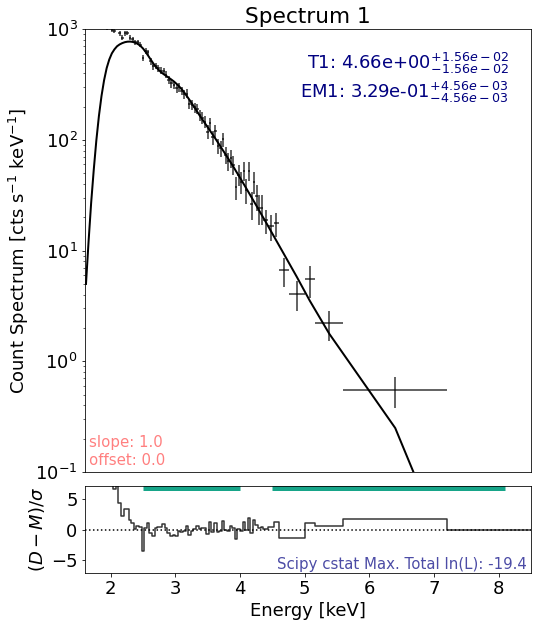

In [15]:
# To save the fitting class 
spec.save("../savedFits/test.pickle")

# To load a saved session back in 
from sunxspex.sunxspex_fitting.fitter import load
new_spec = load("../savedFits/test.pickle")

print(new_spec.params)

# run fit again since the energy range being fitted over has been changed after the last fit
new_spec.fit(tol=1e-6) # Scipy minimize tolerance of 1e-6

# plot the data and rebin it JUST FOR PLOTTING, fit was in natural binning
# rebin=10 means the count bins were combined so that all bins had at least 10 counts in them or were ignored
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_single_plot_size)
axes, res_axes = new_spec.plot(rebin=10)
for a in axes:
    a.set_xlim(x_limits)
    a.set_ylim(y_limits)
plt.show()
plt.rcParams['font.size'] = default_font_size

# Easily run an MCMC on your data with your model

In [16]:
mcmc_result = spec.run_mcmc()

100%|███████████████████████████████████████| 1200/1200 [01:15<00:00, 15.93it/s]


MCMC runs are easily burned and are always burned from the original sampling. E.g., burning 50 samples twice still only discards 50 samples, to discard 100 the user needs to just discard 100.

In [17]:
spec.burn_mcmc = 100

Plot the log-probability chains

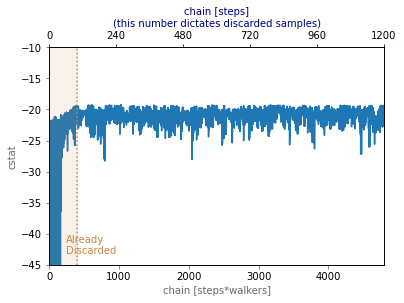

In [18]:
plt.figure()
spec.plot_log_prob_chain()
plt.ylim([-45,-10])
plt.show()

Plot the corner plot from the MCMC run

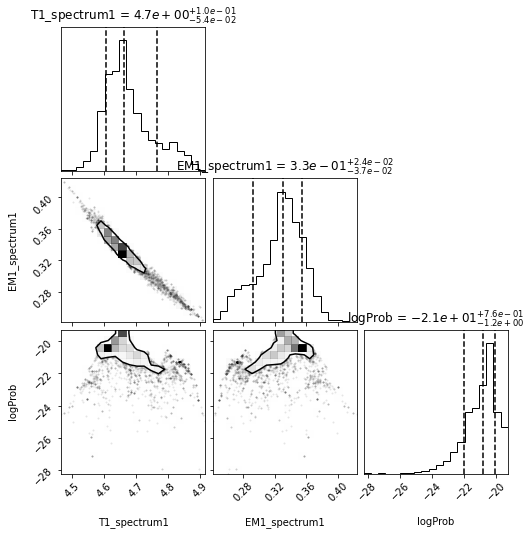

In [19]:
corner_plot = spec.corner_mcmc()

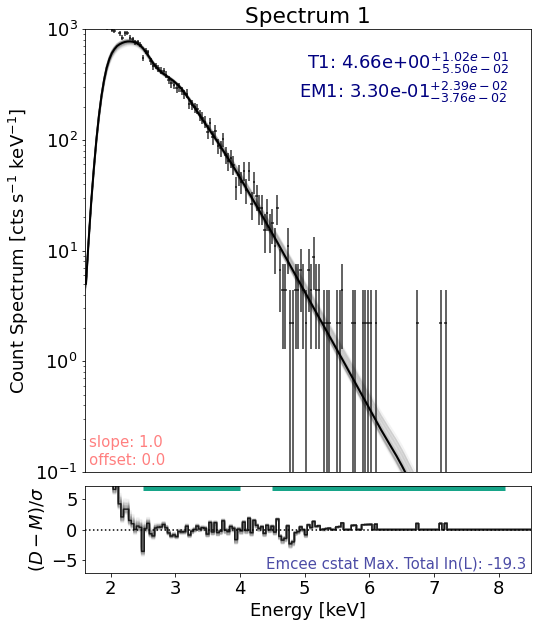

In [20]:
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_single_plot_size)
axes, res_axes = spec.plot()
for a in axes:
    a.set_xlim(x_limits)
    a.set_ylim(y_limits)
plt.show()
plt.rcParams['font.size'] = default_font_size

**Note** that the log-likelihood displayed on the spectral plots show the the maximum log-likelihood found in the MCMC run, not the log-likelihood of the fit.

The log-likelihoods of the median and confidence ranges can be found one the corner plot at the minute and the parameter values that produce these can be found with the mcmc_table attribute.

In [21]:
spec.mcmc_table

Param,LowB,Mid,HighB,MaxLog
str13,float64,float64,float64,float64
T1_spectrum1,4.61,4.66,4.76,4.66
EM1_spectrum1,0.29,0.33,0.35,0.33


An alternative to plotting a number of random MCMC samples as faded lines being the maximum a posteriori (MAP) the user can plot a colour map showing where all run models accumulate counts.

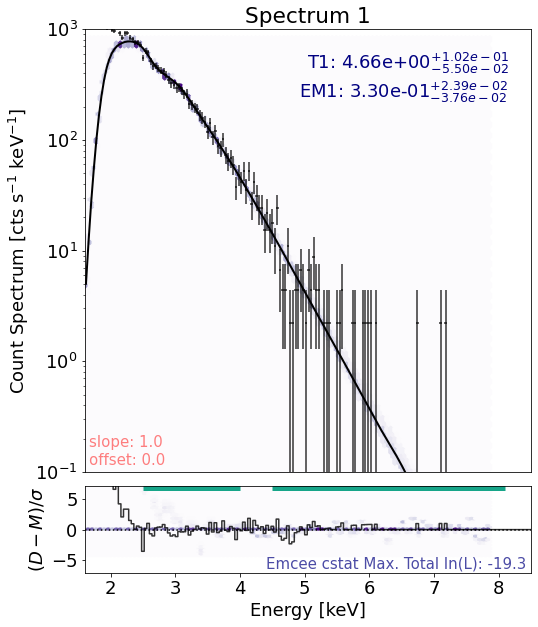

In [22]:
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_single_plot_size)
axes, res_axes = spec.plot(lines_or_hex='hex')
for a in axes:
    a.set_xlim(x_limits)
    a.set_ylim(y_limits)
plt.show()
plt.rcParams['font.size'] = default_font_size

# Might want to fit 2 thermal models and NuSTAR has 2 telescopes...

## Fit 2 spectra simultaneously with two thermal models

In [23]:
%%time
# First, load in your data files, here we load in 2 spectra
_dir = "../nustarData/m10_1616_1620/"
spec = SunXspex(pha_file=[_dir+'nu80415202001A06_chu13_N_cl_grade0_sr.pha', 
                          _dir+'nu80415202001B06_chu13_N_cl_grade0_sr.pha'])
                
# All the data can be accessed via spec.loaded_spec_data
                
# Next you can define a model, here we go for a 2 component isothermal model
# C parameter accounts for systematic offset between two different telescopes
spec.model = "C*(f_vth + f_vth)"

# Set your count energy fitting range. Here we choose 2.5--8.1 keV
spec.energy_fitting_range = [2.5,8.1]
                
# spec.params can be accessed either through the headings for the parameter name.
# To tie one parameter to another we can either set that parameter to the one we want to tie it to or use ["tie", "tied", "bind", "tether", "join", "joined", "in_a_relationship_with"] with _param_to_tie_to
spec.params["T1_spectrum2"] = spec.params["T1_spectrum1"]
spec.params["EM1_spectrum2"] = spec.params["EM1_spectrum1"]
spec.params["T2_spectrum2"] = "JoIn_T2_spectrum1"
spec.params["EM2_spectrum2"] = {"Status":"bind_EM2_spectrum1"}
                
# To stop a parameter from varying we can set its Status to ["frozen", "freeze", "chill", "fix", "fixed", "secure", "stick", "glue", "preserve", "cannot_move", "cant_move", "canny_move", "married"]
# spec.params["C_spectrum1"] = "frozen" is equivalent
spec.params["C_spectrum1"] = {"Status":"frozen"}

# To set the initial value and boundary of your parameters we can do the following.
spec.params["T1_spectrum1"] = {"Value":3.05, "Bounds":(2.5, 6)}
spec.params["EM1_spectrum1"] = {"Value":1.7, "Bounds":(0.5, 3.5)}     
spec.params["T2_spectrum1"] = {"Value":6.6, "Bounds":(4, 10)}                
spec.params["EM2_spectrum1"] = {"Value":0.004, "Bounds":(1e-4, 2e-1)}                
spec.params["C_spectrum2"] = {"Bounds":(0.5, 2)}

# Setting spec.params["param_spec"] = string will set the Status, spec.params["param_spec"] = int or float will set the Value, spec.params["param_spec"] = tuple will set the Bounds
# I.e., spec.params["T1_spectrum1"] = {"Value":3.05, "Bounds":(2.5, 6)} is the same as doing spec.params["T1_spectrum1"]=3.05 and then spec.params["T1_spectrum1"]=(2.5, 6)
                
# To allow a parameter to vary after being fixed simply set its Status to any of these ["free", "thaw", "loose", "unrestrained", "release", "released", "can_move", "single"]

print(spec.params)

                          Status  Value         Bounds       Error
T1_spectrum1                free  3.050       (2.5, 6)  (0.0, 0.0)
EM1_spectrum1               free  1.700     (0.5, 3.5)  (0.0, 0.0)
T2_spectrum1                free  6.600        (4, 10)  (0.0, 0.0)
EM2_spectrum1               free  0.004  (0.0001, 0.2)  (0.0, 0.0)
C_spectrum1               frozen  1.000    (0.0, None)  (0.0, 0.0)
T1_spectrum2    tie_T1_spectrum1  1.000    (0.0, None)  (0.0, 0.0)
EM1_spectrum2  tie_EM1_spectrum1  1.000    (0.0, None)  (0.0, 0.0)
T2_spectrum2    tie_T2_spectrum1  1.000    (0.0, None)  (0.0, 0.0)
EM2_spectrum2  tie_EM2_spectrum1  1.000    (0.0, None)  (0.0, 0.0)
C_spectrum2                 free  1.000       (0.5, 2)  (0.0, 0.0)
CPU times: user 3.63 s, sys: 410 ms, total: 4.04 s
Wall time: 4.91 s


In [24]:
# can also display parameter table as an astropy table
print(spec.show_params)

    Param           Status      ...     Bounds             Error          
                                ...   (min, max)           (-, +)         
------------- ----------------- ... ------------- ------------------------
 T1_spectrum1              free ...      (2.5, 6) (  0.00e+00,   0.00e+00)
EM1_spectrum1              free ...    (0.5, 3.5) (  0.00e+00,   0.00e+00)
 T2_spectrum1              free ...       (4, 10) (  0.00e+00,   0.00e+00)
EM2_spectrum1              free ... (0.0001, 0.2) (  0.00e+00,   0.00e+00)
  C_spectrum1            frozen ...   (0.0, None) (  0.00e+00,   0.00e+00)
 T1_spectrum2  tie_T1_spectrum1 ...   (0.0, None) (  0.00e+00,   0.00e+00)
EM1_spectrum2 tie_EM1_spectrum1 ...   (0.0, None) (  0.00e+00,   0.00e+00)
 T2_spectrum2  tie_T2_spectrum1 ...   (0.0, None) (  0.00e+00,   0.00e+00)
EM2_spectrum2 tie_EM2_spectrum1 ...   (0.0, None) (  0.00e+00,   0.00e+00)
  C_spectrum2              free ...      (0.5, 2) (  0.00e+00,   0.00e+00)
    Fit Stat.       cstat

In spectrum1: 1  counts are left over from binning (bin min. 5) and will not be included when fitting or shown when plotted.
In spectrum2: 1  counts are left over from binning (bin min. 5) and will not be included when fitting or shown when plotted.
In combined: 1.5  counts are left over from binning (bin min. 5) and will not be included when fitting or shown when plotted.


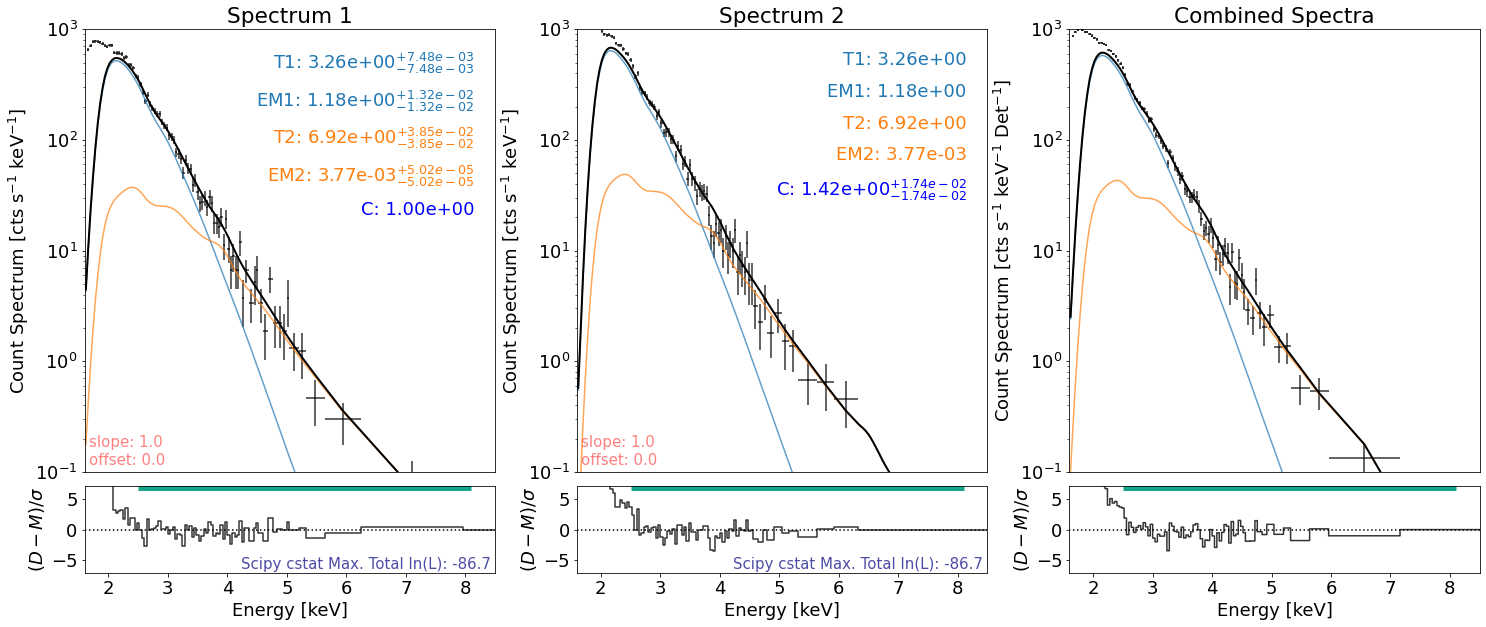

In [25]:
minimised_params = spec.fit()

plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_plot_size)
axes, res_axes = spec.plot(rebin=5)
for a in axes:
    a.set_xlim(x_limits)
    a.set_ylim(y_limits)
plt.show()
plt.rcParams['font.size'] = default_font_size

Compare to XSPEC fits of the same spectra (microflare 10, pre-flare, from [cooper *et al.* 2021](https://academic.oup.com/mnras/article/507/3/3936/6354806)):

| Model Parameter                | XSPEC (Cooper et al. 2021)            | This Work                       |
| :---                           |    :----:                             |                            ---: |
| Temperature 1 [MK]             | 3.05$^{+0.04}_{-0.35}$                | 3.26$\pm$0.01                   |
| Emission Measure 1 [cm$^{-3}$] | 1.70$^{+1.99}_{-0.08}\times$10$^{47}$ | 1.18$\pm$0.01$\times$10$^{46}$  |
| Temperature 2 [MK]             | 6.60$^{+0.20}_{-0.61}$                | 6.92$\pm$0.04                   |
| Emission Measure 2 [cm$^{-3}$] | 3.8$^{+4.0}_{-0.7}\times$10$^{43}$    | 3.77$\pm$0.05$\times$10$^{43}$  |

Although these values are slightly different (almost or are within error margins), it is important to note that XSPEC and SunXspex work from different atomic databases. We also note that for a similar isothermal fit the temperature can drop/rise if the emission measure rises/drops and so fitting not just one but two of these models allows for these to vary more. We do see that this work (for this microflare time) produces slightly higher temperatures but correspondingly lower emission measures. 

### Other (equivalent) ways to define the same model:

In [26]:
# Defining a model in a functional form ensure that the energies input is a keyword with default None. E.g., f(...,energies=None)
# This is different to adding a user component model to be used in string format where energies needs to be the first input argument. E.g., f(energies...)
model_2therm = lambda T1, EM1, T2, EM2, C, energies=None: C*(f_vth(energies, T1, EM1) + f_vth(energies, T2, EM2))
                
def model_2therm(T1, EM1, T2, EM2, C, energies=None):
    return C*(f_vth(energies, T1, EM1) + f_vth(energies, T2, EM2))
                
model_2therm = "C*(f_vth + f_vth)"

spec.model = model_2therm

Model already assigned. If you want to change model please set property "update_model".


If a model if defined via a string (e.g., "C*(f_vth + f_vth)") then the component models will be plotted in different colours once plotted. These other methods will only allow the total resultant model to be plotted but allow for more complex models to be created by the user. 

### Set different fitting ranges for each spectrum

In spectrum1: 10  counts are left over from binning (bin min. 12) and will not be included when fitting or shown when plotted.
In spectrum2: 11  counts are left over from binning (bin min. 12) and will not be included when fitting or shown when plotted.
In combined: 9.5  counts are left over from binning (bin min. 12) and will not be included when fitting or shown when plotted.


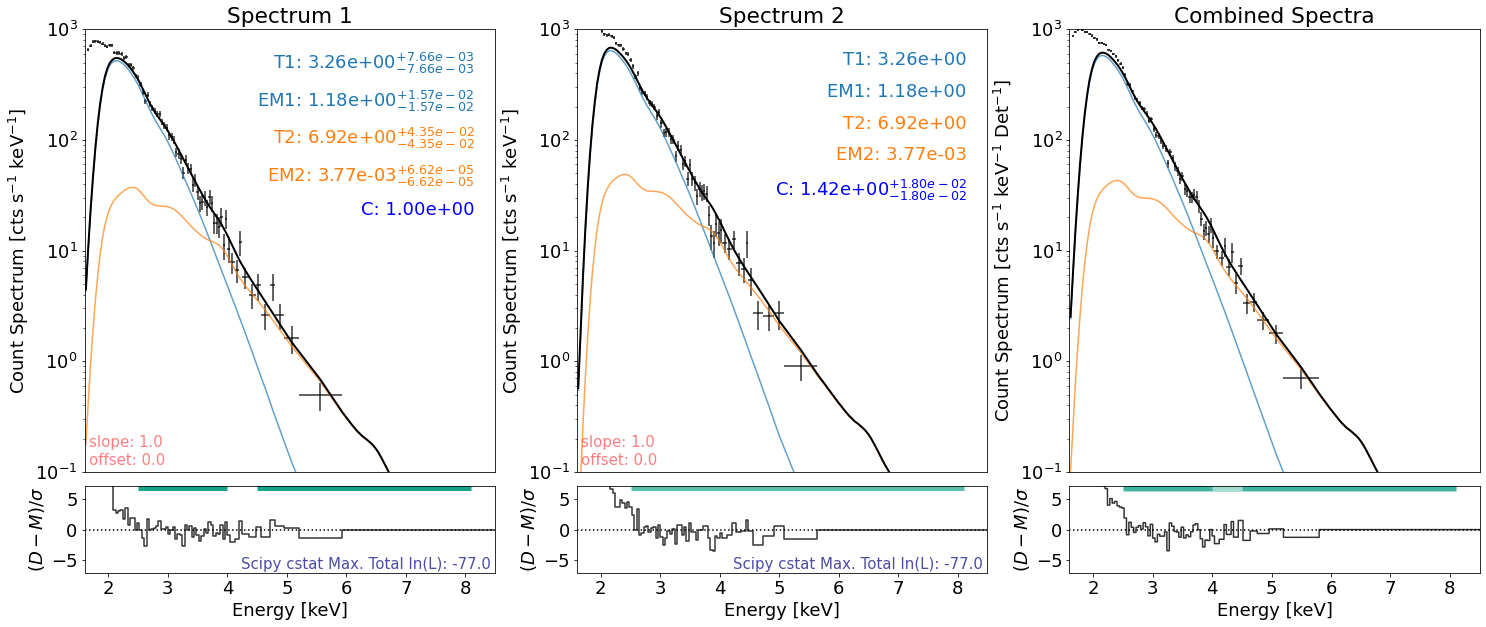

In [27]:
# To fit the energy range while missing bins:
spec.energy_fitting_range = [[2.5,4], [4.5,8.1]]
# This only will fit the counts from 2.5--4 keV and 4.5--8.1 keV and is applied to all spectra loaded

# To vary the fitting range per spectrum, say if we have two spectra loaded:
spec.energy_fitting_range = {"spectrum1":[[2.5,4], [4.5,8.1]], "spectrum2":[[2.5,8.1]]}


# then fit and plot again...
minimised_params = spec.fit()
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_plot_size)
axes, res_axes = spec.plot(rebin=12)
for a in axes:
    a.set_xlim(x_limits)
    a.set_ylim(y_limits)
plt.show()
plt.rcParams['font.size'] = default_font_size

# Add user defined model

In [28]:

# defined_photon_models dict is what the SunXspex fitting uses to know what functions it can use to build with
from sunxspex.sunxspex_fitting.fitter import defined_photon_models, add_photon_model

# See what models are defined
# at the minute this is just the already defined module models {'f_vth': ['T', 'EM'], 'thick_fn': ['total_eflux', 'index', 'e_c'], ...}
print("Defined models:\n",defined_photon_models)

# Define your model. Must have energies as the first entry followed by any variable parameters you want. Spectrum in units of photons s^-1 cm^-2 keV^-1
# parameter names cannot be any already defined in defined_photon_models
def gauss(energies, a, b, c):
    mid_x = np.mean(energies, axis=1) # energies is given as energy bins, e.g., [[2.5,2.6], [2.6,2.7], [2.7,2.8], ...]
    return a * np.exp(-((mid_x-b)**2/(2*c**2)))

# Essentially this is adding your model to the namespace that the fitting process uses to see what models are available to use
add_photon_model(gauss)

print("Defined models, user\'s now included':\n",defined_photon_models)
# Now defined_photon_models is {'f_vth': ['T', 'EM'], 'thick_fn': ['total_eflux', 'index', 'e_c'], ..., 'gauss': ['a', 'b', 'c']} and can use the gauss function

# Now can use the user defined gauss model with already defined module models
# E.g. (use .update_model since the last one was "C*(f_vth + f_vth)" and still exists for spec object),

spec.update_model = "f_vth+gauss"

# spec.params.param_name -> [T1_spectrum1,EM1_spectrum1,a1_spectrum1,b1_spectrum1,c1_spectrum1]

print("Parameters\n",spec.params)

Defined models:
 {'f_vth': ['T', 'EM'], 'thick_fn': ['total_eflux', 'index', 'e_c'], 'thick_warm': ['tot_eflux', 'indx', 'ec', 'plasmaD', 'loopT', 'length']}
gauss
Defined models, user's now included':
 {'f_vth': ['T', 'EM'], 'thick_fn': ['total_eflux', 'index', 'e_c'], 'thick_warm': ['tot_eflux', 'indx', 'ec', 'plasmaD', 'loopT', 'length'], 'gauss': ['a', 'b', 'c']}
Parameters
               Status  Value       Bounds       Error
T1_spectrum1    free    1.0  (0.0, None)  (0.0, 0.0)
EM1_spectrum1   free    1.0  (0.0, None)  (0.0, 0.0)
a1_spectrum1    free    1.0  (0.0, None)  (0.0, 0.0)
b1_spectrum1    free    1.0  (0.0, None)  (0.0, 0.0)
c1_spectrum1    free    1.0  (0.0, None)  (0.0, 0.0)
T1_spectrum2    free    1.0  (0.0, None)  (0.0, 0.0)
EM1_spectrum2   free    1.0  (0.0, None)  (0.0, 0.0)
a1_spectrum2    free    1.0  (0.0, None)  (0.0, 0.0)
b1_spectrum2    free    1.0  (0.0, None)  (0.0, 0.0)
c1_spectrum2    free    1.0  (0.0, None)  (0.0, 0.0)


#### Can now use gauss photon model in the fitting, either by itself or in a greater, overall model defined as a named function, lambda function, or string

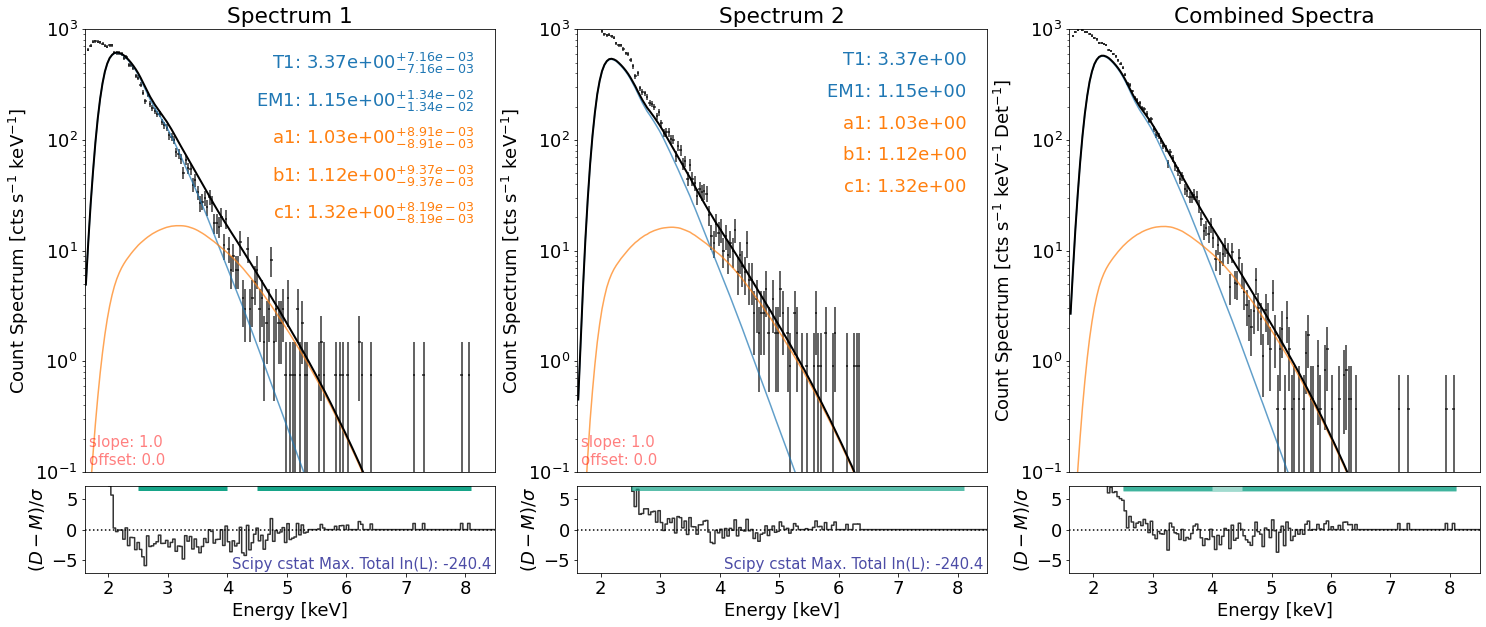

In [29]:
# sort parameters
spec.params["T1_spectrum1"] = {"Value":3.05, "Bounds":(2.5, 6)}
spec.params["EM1_spectrum1"] = {"Value":1.7, "Bounds":(0.5, 3.5)} 
spec.params["T1_spectrum2"] = spec.params["T1_spectrum1"]
spec.params["EM1_spectrum2"] = spec.params["EM1_spectrum1"]
spec.params["a1_spectrum2"] = spec.params["a1_spectrum1"]
spec.params["b1_spectrum2"] = spec.params["b1_spectrum1"]
spec.params["c1_spectrum2"] = spec.params["c1_spectrum1"]

# then fit and plot again...
minimised_params = spec.fit()

plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_plot_size)
axes, res_axes = spec.plot()
for a in axes:
    a.set_xlim(x_limits)
    a.set_ylim(y_limits)
plt.show()
plt.rcParams['font.size'] = default_font_size

# Can alter the gain parameters

Gain parameters can be tweaked in the same way model parameters can.

The difference is that gain parameters all have specific starting values (slope=1, offset=0) and are frozen by default.

In [30]:
print(spec.rParams)

                       Status  Value       Bounds       Error
gain_slope_spectrum1   frozen    1.0   (0.8, 1.2)  (0.0, 0.0)
gain_offset_spectrum1  frozen    0.0  (-0.1, 0.1)  (0.0, 0.0)
gain_slope_spectrum2   frozen    1.0   (0.8, 1.2)  (0.0, 0.0)
gain_offset_spectrum2  frozen    0.0  (-0.1, 0.1)  (0.0, 0.0)


In [31]:
print(spec.show_rParams)

        Param         Status   Value       Bounds            Error          
                                         (min, max)          (-, +)         
--------------------- ------ ---------- ----------- ------------------------
 gain_slope_spectrum1 frozen      1.000  (0.8, 1.2) (      0.00,       0.00)
gain_offset_spectrum1 frozen      0.000 (-0.1, 0.1) (      0.00,       0.00)
 gain_slope_spectrum2 frozen      1.000  (0.8, 1.2) (      0.00,       0.00)
gain_offset_spectrum2 frozen      0.000 (-0.1, 0.1) (      0.00,       0.00)


# Let's fit a more realistic example

Try fitting the spectra presented in [Glesener *et al.* 2020](https://iopscience.iop.org/article/10.3847/2041-8213/ab7341). The spectrum presented show clear evidence of non-thermal emission in an A5.7 microflare.

### Let's recreate Figure 4 (left) where NuSTAR FPMB is fitted with a thermal+cold thick target model.

In [32]:
# set up plotting info stuff
gles_xlims, gles_ylims = [2,12], [1e1,1e4]

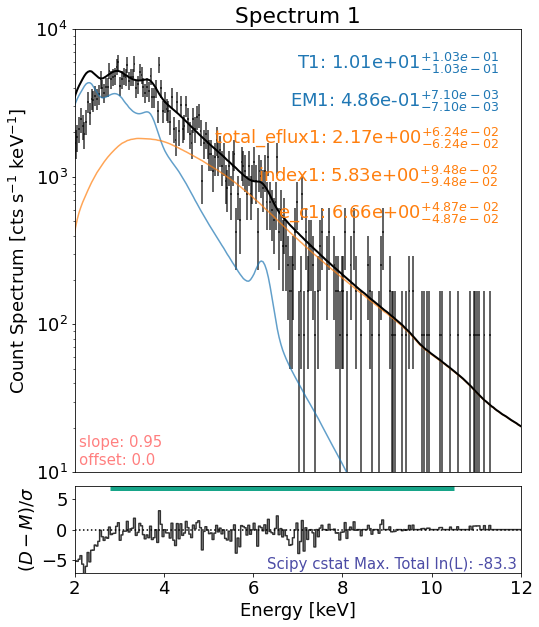

CPU times: user 1min 10s, sys: 15.5 s, total: 1min 26s
Wall time: 32.4 s


In [33]:
%%time
# First, load in your data files, here we load in 2 spectra
_dir = "../nustarData/Lindsays_NonThermalEvent/"
# in the files I have, the ARF and RMF file have different names to the PHA files so cannot use the PHA file name to help find the others so...
spec = SunXspex(pha_file=_dir+'nu20312001001B06_cl_grade0_sr_grp.pha',
                arf_file=_dir+'nu20312001001B06_cl_grade0_sr.arf',
                rmf_file=_dir+'nu20312001001B06_cl_grade0_sr.rmf')
                
# define model, here we go for a single isothermal model + cold thick model
spec.model = "f_vth + thick_fn"

# define fitting range
spec.energy_fitting_range = [2.8,10.5]

# sort temperature param from f_vth
spec.params["T1_spectrum1"] = {"Value":10.3, "Bounds":(1.1, 15)}
# emission measure param from f_vth
spec.params["EM1_spectrum1"] = {"Value":0.5, "Bounds":(1e-2, 1e1)}
# electron flux param from thick_fn
spec.params["total_eflux1_spectrum1"] = {"Value":2.1, "Bounds":(1e-3, 10)} # units 1e35 e^-/s
# electron index param from thick_fn
spec.params["index1_spectrum1"] = {"Value":6.2, "Bounds":(3, 10)}
# electron low energy cut-off param from thick_fn
spec.params["e_c1_spectrum1"] = {"Value":6.2, "Bounds":(1, 12)} # units keV
# constant for systematic offset between FPMs, found to be about 1.1
# from Gles. 2020 which had a gain correction fixed at 0.95
spec.rParams["gain_slope_spectrum1"] = {"Status":"fixed", "Value":0.95}

# fit the model to the spectrum
spec.fit(tol=1e-8)

# plot the result
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_single_plot_size)
axes, res_axes = spec.plot()
for a in axes:
    a.set_xlim(gles_xlims)
    a.set_ylim(gles_ylims)
plt.show()
plt.rcParams['font.size'] = default_font_size

### Let's recreate Figure 3(c) where both NuSTAR FPMs are fitted with a thermal+cold thick target model simultaneously.

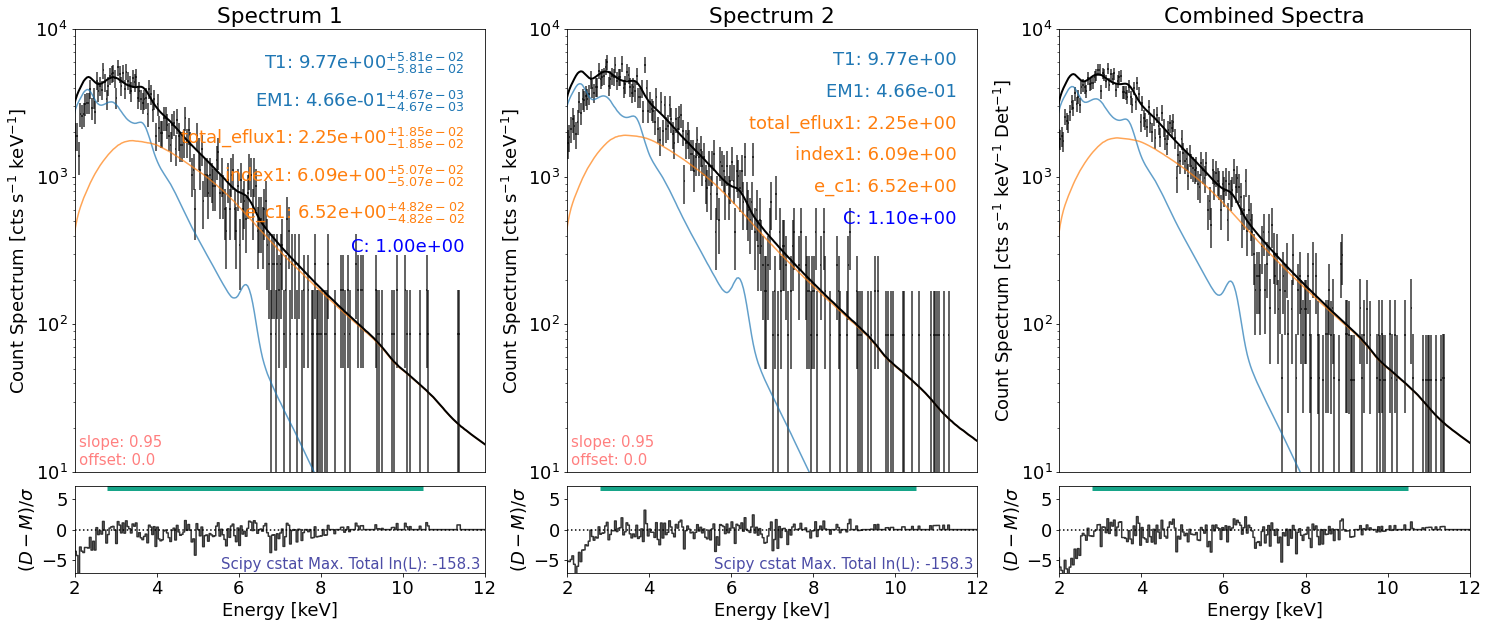

CPU times: user 2min 28s, sys: 32.2 s, total: 3min
Wall time: 1min


In [34]:
%%time
# First, load in your data files, here we load in 2 spectra
_dir = "../nustarData/Lindsays_NonThermalEvent/"
# in the files I have, the ARF and RMF file have different names to the PHA files so cannot use the PHA file name to help find the others so...
spec = SunXspex(pha_file=[_dir+'nu20312001001A06_cl_grade0_sr_grp.pha',
                          _dir+'nu20312001001B06_cl_grade0_sr_grp.pha'],
                arf_file=[_dir+'nu20312001001A06_cl_grade0_sr.arf',
                          _dir+'nu20312001001B06_cl_grade0_sr.arf'],
                rmf_file=[_dir+'nu20312001001A06_cl_grade0_sr.rmf',
                          _dir+'nu20312001001B06_cl_grade0_sr.rmf'])
                
# define model, here we go for a single isothermal model + cold thick model
spec.model = "C*(f_vth + thick_fn)"

# define fitting range
spec.energy_fitting_range = [2.8,10.5]

# sort temperature param from f_vth
spec.params["T1_spectrum1"] = {"Value":10.3, "Bounds":(1.1, 15)}
spec.params["T1_spectrum2"] = spec.params["T1_spectrum1"]
# emission measure param from f_vth
spec.params["EM1_spectrum1"] = {"Value":0.5, "Bounds":(1e-2, 1e1)}
spec.params["EM1_spectrum2"] = spec.params["EM1_spectrum1"]
# electron flux param from thick_fn
spec.params["total_eflux1_spectrum1"] = {"Value":2.1, "Bounds":(1e-3, 10)} # units 1e35 e^-/s
spec.params["total_eflux1_spectrum2"] = spec.params["total_eflux1_spectrum1"]
# electron index param from thick_fn
spec.params["index1_spectrum1"] = {"Value":6.2, "Bounds":(3, 10)}
spec.params["index1_spectrum2"] = spec.params["index1_spectrum1"]
# electron low energy cut-off param from thick_fn
spec.params["e_c1_spectrum1"] = {"Value":6.2, "Bounds":(1, 12)} # units keV
spec.params["e_c1_spectrum2"] = spec.params["e_c1_spectrum1"]
# constant for systematic offset between FPMs, found to be about 1.1
spec.params["C_spectrum1"] = "frozen"
spec.params["C_spectrum2"] = {"Status":"fixed", "Value":1.1}
# from Gles. 2020 which had a gain correction fixed at 0.95
spec.rParams["gain_slope_spectrum1"] = {"Status":"fixed", "Value":0.95}
spec.rParams["gain_slope_spectrum2"] = spec.rParams["gain_slope_spectrum1"]

# fit the model to the spectrum
spec.fit(tol=1e-8)

# plot the result
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_plot_size)
axes, res_axes = spec.plot()
for a in axes:
    a.set_xlim(gles_xlims)
    a.set_ylim(gles_ylims)
plt.show()
plt.rcParams['font.size'] = default_font_size

For the thermal and cold thick target total model:

| Model Parameter                  | OSPEX (Glesener et al. 2020, just FPMB)       |This Work (just FPMB)           | This Work (FPMA&B)                |
| :---                             |    :----:                                     |     :----:                     |                              ---: |
| Temperature [MK]                 | 10.3$^{+0.7}_{-0.7}$                          | 10.12$\pm$0.10                 | 9.77$\pm$0.06                     |
| Emission Measure [cm$^{-3}$]     | 5.0$^{+1.3}_{-1.3}\times$10$^{45}$            | 4.86$\pm$0.01$\times$10$^{45}$ | 4.66$\pm$0.05$\times$10$^{45}$    |
| Electron Flux [e$^{-}$ s$^{-1}$] | 2.1$^{+1.2}_{-1.2}\times$10$^{35}$            | 2.17$\pm$0.06$\times$10$^{35}$ | 2.25$\pm$0.02$\times$10$^{35}$    |
| Index                            | 6.2$^{+0.6}_{-0.6}$                           | 5.83$\pm$0.09                  | 6.09$\pm$0.05                     |
| Low Energy Cut-off [keV]         | 6.2$^{+0.9}_{-0.9}$                           | 6.66$\pm$0.05                  | 6.52$\pm$0.05                     |

### Let's recreate Figure 4 (right) where NuSTAR FPMB is fitted with a warm thick target model.

### The warm thick target model helps to constrain the non-thermal emission with observed values (e.g., loop length, etc).

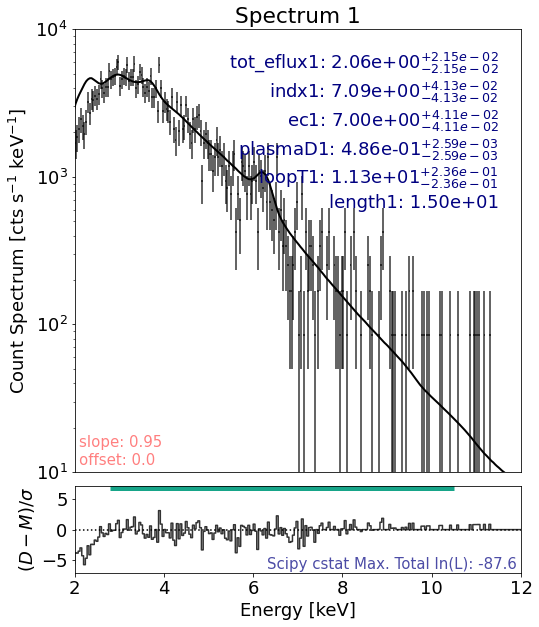

CPU times: user 1min 29s, sys: 19.1 s, total: 1min 48s
Wall time: 34.9 s


In [35]:
%%time
# First, load in your data files, here we load in 1 spectrum
_dir = "../nustarData/Lindsays_NonThermalEvent/"
spec = SunXspex(pha_file=_dir+'nu20312001001B06_cl_grade0_sr_grp.pha',
                arf_file=_dir+'nu20312001001B06_cl_grade0_sr.arf',
                rmf_file=_dir+'nu20312001001B06_cl_grade0_sr.rmf')
                
# define model, here we go for a single isothermal model + cold thick model
spec.model = "thick_warm"

# define fitting range
spec.energy_fitting_range = [2.8,10.5]

## Note that similar parameters in the warm thick target and cold thick target models have slightly different names
# electron flux param
spec.params["tot_eflux1_spectrum1"] = {"Value":2, "Bounds":(1e-2, 10)}
# electron index param
spec.params["indx1_spectrum1"] = {"Value":6, "Bounds":(3, 10)}
# electron low energy cut-off param 
spec.params["ec1_spectrum1"] = {"Value":7, "Bounds":(3, 12)}
# loop plasma temperature param 
spec.params["loopT1_spectrum1"] = {"Value":10, "Bounds":(5, 15)}
# plasma number density param 
spec.params["plasmaD1_spectrum1"] = {"Value":1, "Bounds":(1e-2, 1e1)} # units 1e10 cm^-3
# loop length param 
spec.params["length1_spectrum1"] = {"Status":"fixed", "Value":15} # units Mm
# from Gles. 2020 which had a gain correction fixed at 0.95
spec.rParams["gain_slope_spectrum1"] = {"Status":"fixed", "Value":0.95}

# fit the model to the spectrum
spec.fit(tol=1e-10)

# plot the result
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_single_plot_size)
axes, res_axes = spec.plot()
for a in axes:
    a.set_xlim(gles_xlims)
    a.set_ylim(gles_ylims)
plt.show()
plt.rcParams['font.size'] = default_font_size

#### Here we can now fit the warm thick target model to both FPMs simultaneously

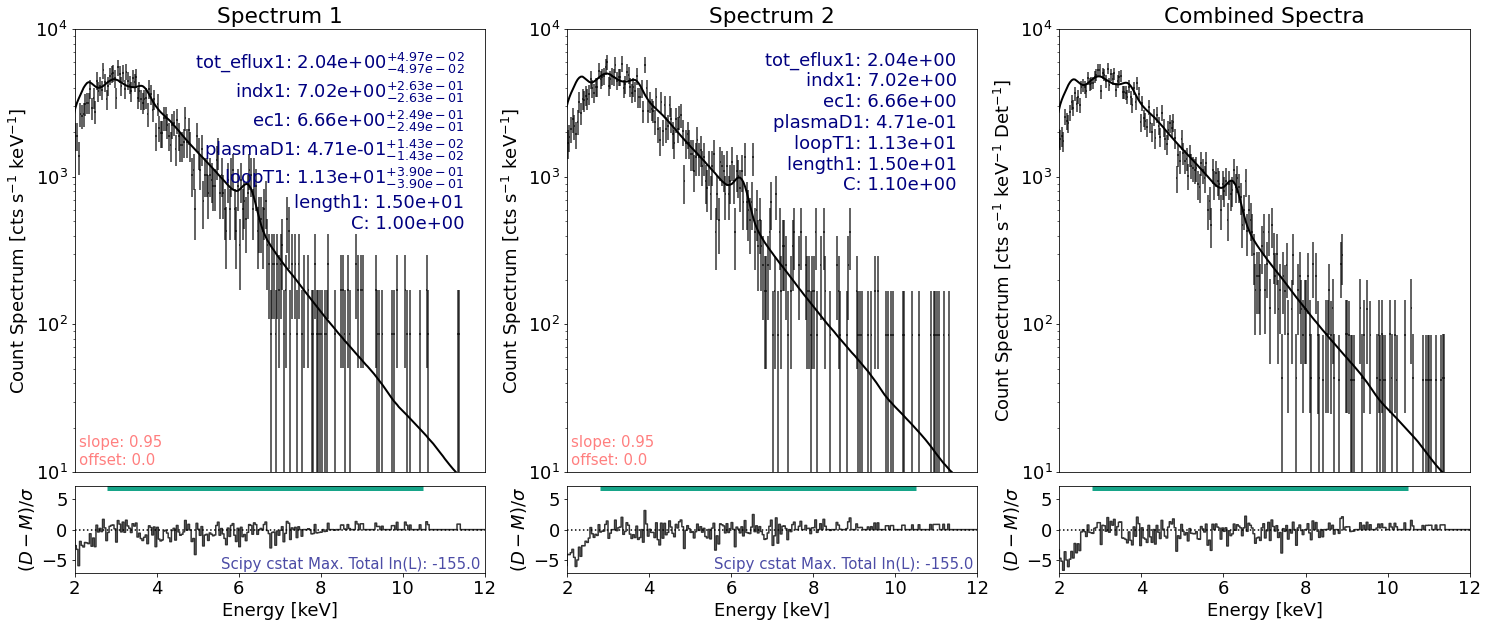

CPU times: user 2min 9s, sys: 27.1 s, total: 2min 36s
Wall time: 53.5 s


In [36]:
%%time
# First, load in your data files, here we load in 2 spectra
_dir = "../nustarData/Lindsays_NonThermalEvent/"
spec = SunXspex(pha_file=[_dir+'nu20312001001A06_cl_grade0_sr_grp.pha',
                          _dir+'nu20312001001B06_cl_grade0_sr_grp.pha'],
                arf_file=[_dir+'nu20312001001A06_cl_grade0_sr.arf',
                          _dir+'nu20312001001B06_cl_grade0_sr.arf'],
                rmf_file=[_dir+'nu20312001001A06_cl_grade0_sr.rmf',
                          _dir+'nu20312001001B06_cl_grade0_sr.rmf'])
                
# define model, here we go for a single isothermal model + cold thick model
spec.model = "C*thick_warm"

# define fitting range
spec.energy_fitting_range = [2.8,10.5]

## Note that similar parameters in the warm thick target and cold thick target models have slightly different names
# electron flux param
spec.params["tot_eflux1_spectrum1"] = {"Value":2, "Bounds":(1e-3, 10)}
spec.params["tot_eflux1_spectrum2"] = spec.params["tot_eflux1_spectrum1"]
# electron index param
spec.params["indx1_spectrum1"] = {"Value":6, "Bounds":(3, 10)}
spec.params["indx1_spectrum2"] = spec.params["indx1_spectrum1"]
# electron low energy cut-off param 
spec.params["ec1_spectrum1"] = {"Value":7, "Bounds":(1, 12)}
spec.params["ec1_spectrum2"] = spec.params["ec1_spectrum1"]
# loop plasma temperature param 
spec.params["loopT1_spectrum1"] = {"Value":10, "Bounds":(1.1, 15)}
spec.params["loopT1_spectrum2"] = spec.params["loopT1_spectrum1"]
# plasma number density param 
spec.params["plasmaD1_spectrum1"] = {"Value":1, "Bounds":(1e-2, 1e1)}
spec.params["plasmaD1_spectrum2"] = spec.params["plasmaD1_spectrum1"]
# loop length param 
spec.params["length1_spectrum1"] = {"Status":"fixed", "Value":15}
spec.params["length1_spectrum2"] = spec.params["length1_spectrum1"]
# constant for systematic offset between FPMs, found to be about 1.1
spec.params["C_spectrum1"] = "frozen"
spec.params["C_spectrum2"] = {"Status":"fixed", "Value":1.1}
# from Gles. 2020 which had a gain correction fixed at 0.95
spec.rParams["gain_slope_spectrum1"] = {"Status":"fixed", "Value":0.95}
spec.rParams["gain_slope_spectrum2"] = spec.rParams["gain_slope_spectrum1"]

# fit the model to the spectrum
spec.fit(tol=1e-5)

# plot the result
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_plot_size)
axes, res_axes = spec.plot()
for a in axes:
    a.set_xlim(gles_xlims)
    a.set_ylim(gles_ylims)
plt.show()
plt.rcParams['font.size'] = default_font_size

For the warm thick target total model

| Model Parameter                  | OSPEX (Glesener et al. 2020, just FPMB) |This Work (just FPMB)            | This Work (FPMA&B)              |
| :---                             |    :----:                               |     :----:                      |                            ---: |
| Temperature [MK]                 | 10.2$^{+0.7}_{-0.7}$                    | 11.34$\pm$0.24                  | 11.27$\pm$0.39                  |
| Plasma Density [cm$^{-3}$]       | 6.0$^{+2.0}_{-2.0}\times$10$^{9}$       | 4.86$\pm$0.03$\times$10$^{9}$   | 4.71$\pm$0.14$\times$10$^{9}$   |
| Electron Flux [e$^{-}$ s$^{-1}$] | 1.8$^{+0.8}_{-0.8}\times$10$^{35}$      | 2.06$\pm$0.02$\times$10$^{35}$  | 2.04$\pm$0.05$\times$10$^{35}$  |
| Index                            | 6.3$^{+0.7}_{-0.7}$                     | 7.09$\pm$0.04                   | 7.02$\pm$0.26                   |
| Low Energy Cut-off [keV]         | 6.5$^{+0.9}_{-0.9}$                     | 7.00$\pm$0.04                   | 6.66$\pm$0.25                   |

All parameter values appear to be within error margins (or extrememly close). This is more impresive when the errors calculated in this work for the minimised values assumes the parameter's have a Gaussian and independent posterior distribution (which is clearly not the case) and so these errors are likely to be larger; to be investigated with an MCMC.

# An example of fitting multiple spectra simultaneously with 2 models where each model is allowed to vary at different times

This spectrum corresponds to the may1618 microflare in [Duncan *et al.* 2021](https://iopscience.iop.org/article/10.3847/1538-4357/abca3d).

In [37]:
# set up plotting info stuff
dunc_xlims, dunc_ylims = [2.5,11], [1e0,4e4]

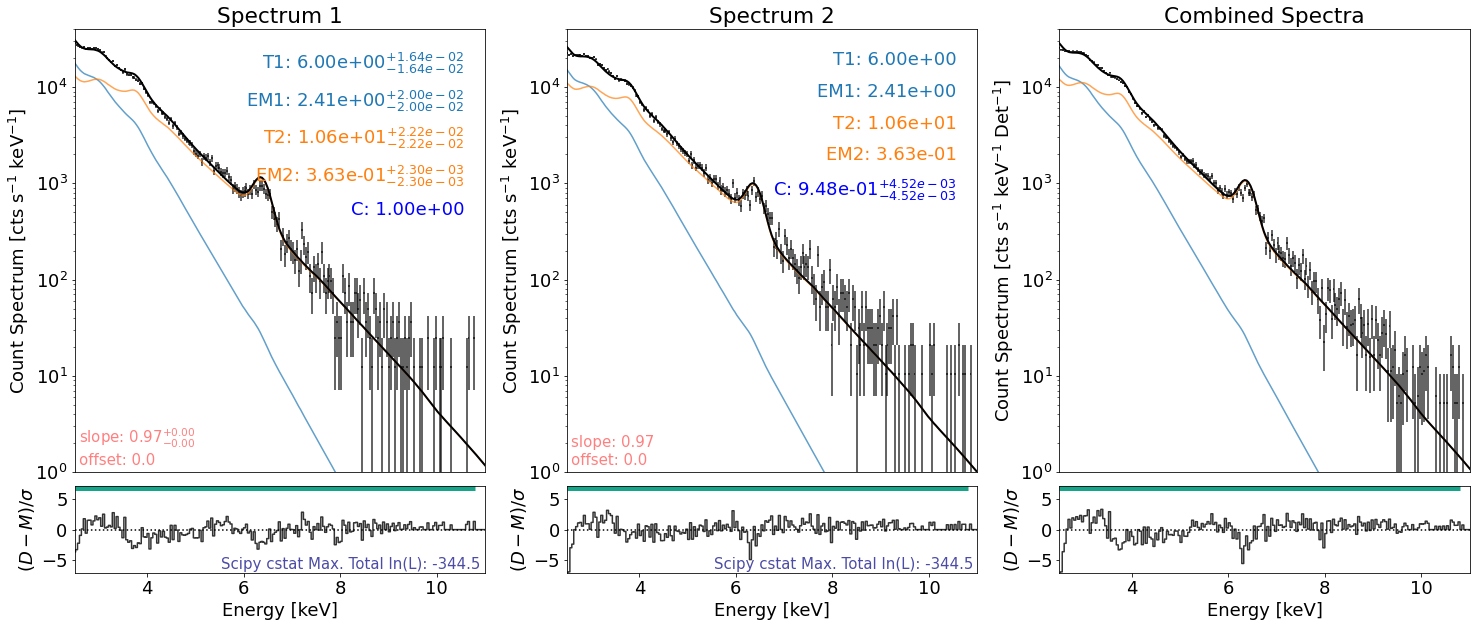

CPU times: user 2min 3s, sys: 22.3 s, total: 2min 25s
Wall time: 58.1 s


In [38]:
%%time
# First, load in your data files, here we load in 2 spectra
_dir = "../nustarData/jessies_spectra/"
spec = SunXspex(pha_file=[_dir+'nu80410201001A06_1618_p_chu2_N_sr.pha',
                          _dir+'nu80410201001B06_1618_p_chu2_N_sr.pha'])

# define model, here we go for 2 isothermal models
spec.model = "C*(f_vth + f_vth)"
                
# tie parameters
spec.params["T1_spectrum2"] = spec.params["T1_spectrum1"]
spec.params["EM1_spectrum2"] = spec.params["EM1_spectrum1"]
spec.params["T2_spectrum2"] = "JoIn_T2_spectrum1"
spec.params["EM2_spectrum2"] = {"Status":"bind_EM2_spectrum1"}
                
# freeze the ones we don't want to vary
spec.params["C_spectrum1"] = {"Status":"frozen"}

# Set initial values
spec.params["T1_spectrum1"] = {"Value":4, "Bounds":(2.5, 6)}
spec.params["EM1_spectrum1"] = {"Value":10, "Bounds":(1e-1, 1e2)}     
spec.params["T2_spectrum1"] = {"Value":8, "Bounds":(5, 15)}                
spec.params["EM2_spectrum1"] = {"Value":0.5, "Bounds":(1e-4, 10)}                
spec.params["C_spectrum2"] = {"Bounds":(0.5, 2)}


# Fit lower energy range with the first thermal model first
spec.params["T2_spectrum1"] = "frozen"
spec.params["EM2_spectrum1"] = "frozen"
spec.energy_fitting_range = [2.5,5]

spec.fit(tol=1e-6)


# Now fit higher energy range with the second thermal model
spec.params["T1_spectrum1"] = "frozen"
spec.params["EM1_spectrum1"] = "frozen"
spec.params["C_spectrum2"] = "frozen"
spec.params["T2_spectrum1"] = "free"
spec.params["EM2_spectrum1"] = "free"

# Need the gain slope to vary too for this microflare but only needed for the 6.7 keV line
spec.rParams["gain_slope_spectrum1"] = "free"
spec.rParams["gain_slope_spectrum2"] = spec.rParams["gain_slope_spectrum1"]

spec.energy_fitting_range = [5, 10.8]

spec.fit(tol=1e-6)


# Now free everything over full range
spec.params["T1_spectrum1"] = "free"
spec.params["EM1_spectrum1"] = "free"
spec.params["C_spectrum2"] = "free"

spec.energy_fitting_range = [2.5, 10.8]

spec.fit(tol=1e-8)

# plot the result
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_plot_size)
axes, res_axes = spec.plot()
for a in axes:
    a.set_xlim(dunc_xlims)
    a.set_ylim(dunc_ylims)
plt.show()
plt.rcParams['font.size'] = default_font_size

For the 2 thermal model fitting:

| Model Parameter                | XSPEC (Duncan et al. 2021)         | This Work                       |
| :---                           |    :----:                          |                            ---: |
| Temperature 1 [MK]             | 4.1$^{+0.2}_{-0.1}$                | 6.00$\pm$0.02                   |
| Emission Measure 1 [cm$^{-3}$] | 1.4$^{+0.6}_{-0.4}\times$10$^{47}$ | 2.41$\pm$0.02$\times$10$^{46}$  |
| Temperature 2 [MK]             | 10.00$^{+0.03}_{-0.03}$            | 10.63$\pm$0.02                  |
| Emission Measure 2 [cm$^{-3}$] | 4.6$^{+0.1}_{-0.2}\times$10$^{45}$ | 3.63$\pm$0.02$\times$10$^{45}$  |


| Response Parameter             | XSPEC (Duncan et al. 2021)         | This Work         |
| :---                           |    :----:                          |              ---: |
| Gain Slope                     | 0.977$\pm$0.002                    | 0.973$\pm$0.001   |

Although these values are slightly different, it is important to note that XSPEC and SunXspex work from different atomic databases. We also note that for a similar isothermal fit the temperature can drop/rise if the emission measure rises/drops and so fitting not just one but two of these models allows for these to vary more. We do see that this work (for this microflare) produces higher temperatures but correspondingly lower emission measures. 

***

**Code is still under construction. The vast majority of code has documentation but still working on it. Plotting code is generally a mess but, again, a work in progress.**

**Working on parallelisation for the MCMC. Numpy already does this for some calculations for the minimisation which gets in the road of the MCMC walker parallelisation.**

**Nested sampling is set up for model comparison, so the method `run_nested()` works, but has not been tested yet.**

***